In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

In [17]:
import pandas as pd
import numpy as np
import mpslib as mps
import matplotlib.pyplot as plt

from scripts.utils import plot_realizations_enhanced

# Setup MPSLib

In [ ]:
simulation_grid_size = [250, 250, 1]    # Output shape
number_of_realizations = 9

template_size = [8, 7, 1]
n_multiple_templates = 3

In [ ]:
# Initialize MPSlib using the mps_snesim_tree algorithm with specified simulation grid
O = mps.mpslib(method='mps_snesim_tree', simulation_grid_size=simulation_grid_size)

# Core simulation parameters
O.par['debug_level'] = -1  # Controls verbosity: -1=silent, 0=minimal, 1+=verbose
O.par['n_cond'] = 10  # Number of conditional data points used for pattern matching
O.par['n_real'] = number_of_realizations  # Number of realizations to generate
O.par['n_threads'] = 10  # Number of parallel threads for computation
O.par['do_entropy'] = 1  # Calculate entropy maps: 0=no, 1=yes

# Grid and template configuration
O.par['simulation_grid_size'] = np.array(simulation_grid_size)  # Output grid dimensions [nx, ny, nz]
O.par['template_size'] = np.array(template_size)  # Search template dimensions [nx, ny, nz]
O.par['n_multiple_grids'] = n_multiple_templates  # Number of multigrid levels for computational efficiency

# Additional default parameters (automatically set by mpslib):
# rseed: Random seed for reproducibility
# n_max_cpdf_count: Maximum conditional probability density function count
# out_folder: Output directory for results
# ti_fnam: Training image filename
# origin: Grid origin coordinates
# grid_cell_size: Cell size in each dimension
# mask_fnam: Mask file for simulation domain
# hard_data_fnam: Hard conditioning data file
# shuffle_simulation_grid: Simulation path strategy (0=sequential, 1=random, 2=preferential)
# entropyfactor_simulation_grid: Entropy factor for preferential path
# shuffle_ti_grid: Training image scanning strategy
# hard_data_search_radius: Search radius for hard data conditioning
# soft_data_categories: Categories for soft data conditioning
# soft_data_fnam: Soft conditioning data file
# do_estimation: Perform estimation instead of simulation
# n_min_node_count: Minimum node count for pattern acceptance

Using mps_genesim installed in /home/pedro2/.local/lib/python3.10/site-packages/mpslib/bin (scikit-mps in /home/pedro2/.local/lib/python3.10/site-packages/mpslib/mpslib.py)
Using mps_snesim_tree installed in /home/pedro2/.local/lib/python3.10/site-packages/mpslib/bin (scikit-mps in /home/pedro2/.local/lib/python3.10/site-packages/mpslib/mpslib.py)


# Choose training image

In [5]:
idx = 4

path = f"../data/eas/Parker_binary_{idx}"
path_eas = path + ".dat"
data_eas = mps.eas.read(filename=path_eas)
data_array = np.load(path + ".npy")
data_transformed_array = np.load(path + "_transformed.npy")

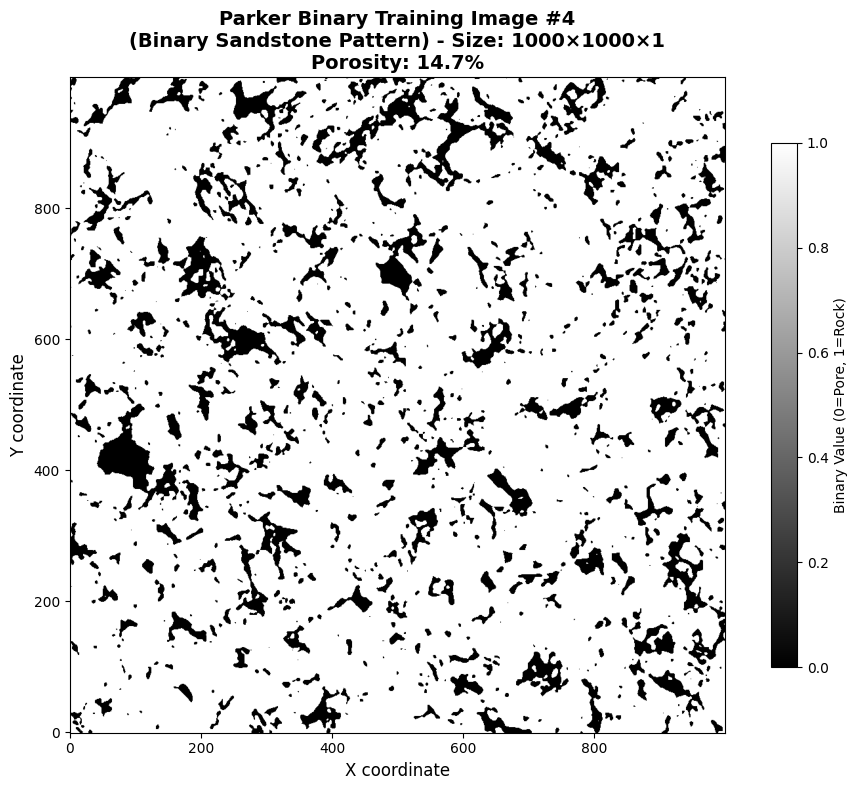

In [ ]:
# Calculate porosity (percentage of pore space, where 0=Pore, 1=Rock)
porosity = np.mean(data_array[:,:,0] == 0) * 100

# Create a larger, better formatted plot
plt.figure(figsize=(10, 8))
plt.imshow(data_array[:,:,0].T, cmap='plasma', origin='lower')
plt.title(f'Parker Binary Training Image #{idx}\n(Binary Sandstone Pattern) - Size: {data_array.shape[0]}×{data_array.shape[1]}×{data_array.shape[2]}\nPorosity: {porosity:.1f}%', fontsize=14, fontweight='bold')
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)
plt.colorbar(label='Binary Value (0=Pore, 1=Rock)', shrink=0.8)
plt.tight_layout()
plt.show()


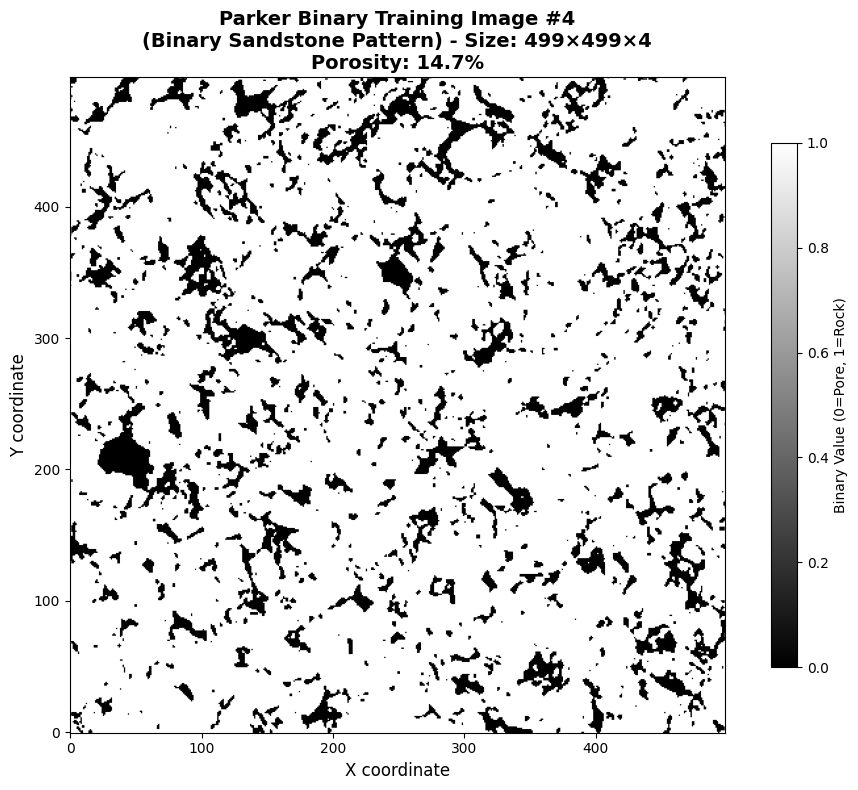

In [ ]:
# Calculate porosity (percentage of pore space, where 0=Pore, 1=Rock)
porosity = np.mean(data_transformed_array[:,:,0] == 0) * 100

# Create a larger, better formatted plot
plt.figure(figsize=(10, 8))
plt.imshow(data_transformed_array[:,:,0].T, cmap='plasma', origin='lower')
plt.title(f'Parker Binary Training Image #{idx}\n(Binary Sandstone Pattern) - Size: {data_transformed_array.shape[0]}×{data_transformed_array.shape[1]}×{data_transformed_array.shape[2]}\nPorosity: {porosity:.1f}%', fontsize=14, fontweight='bold')
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)
plt.colorbar(label='Binary Value (0=Pore, 1=Rock)', shrink=0.8)
plt.tight_layout()
plt.show()


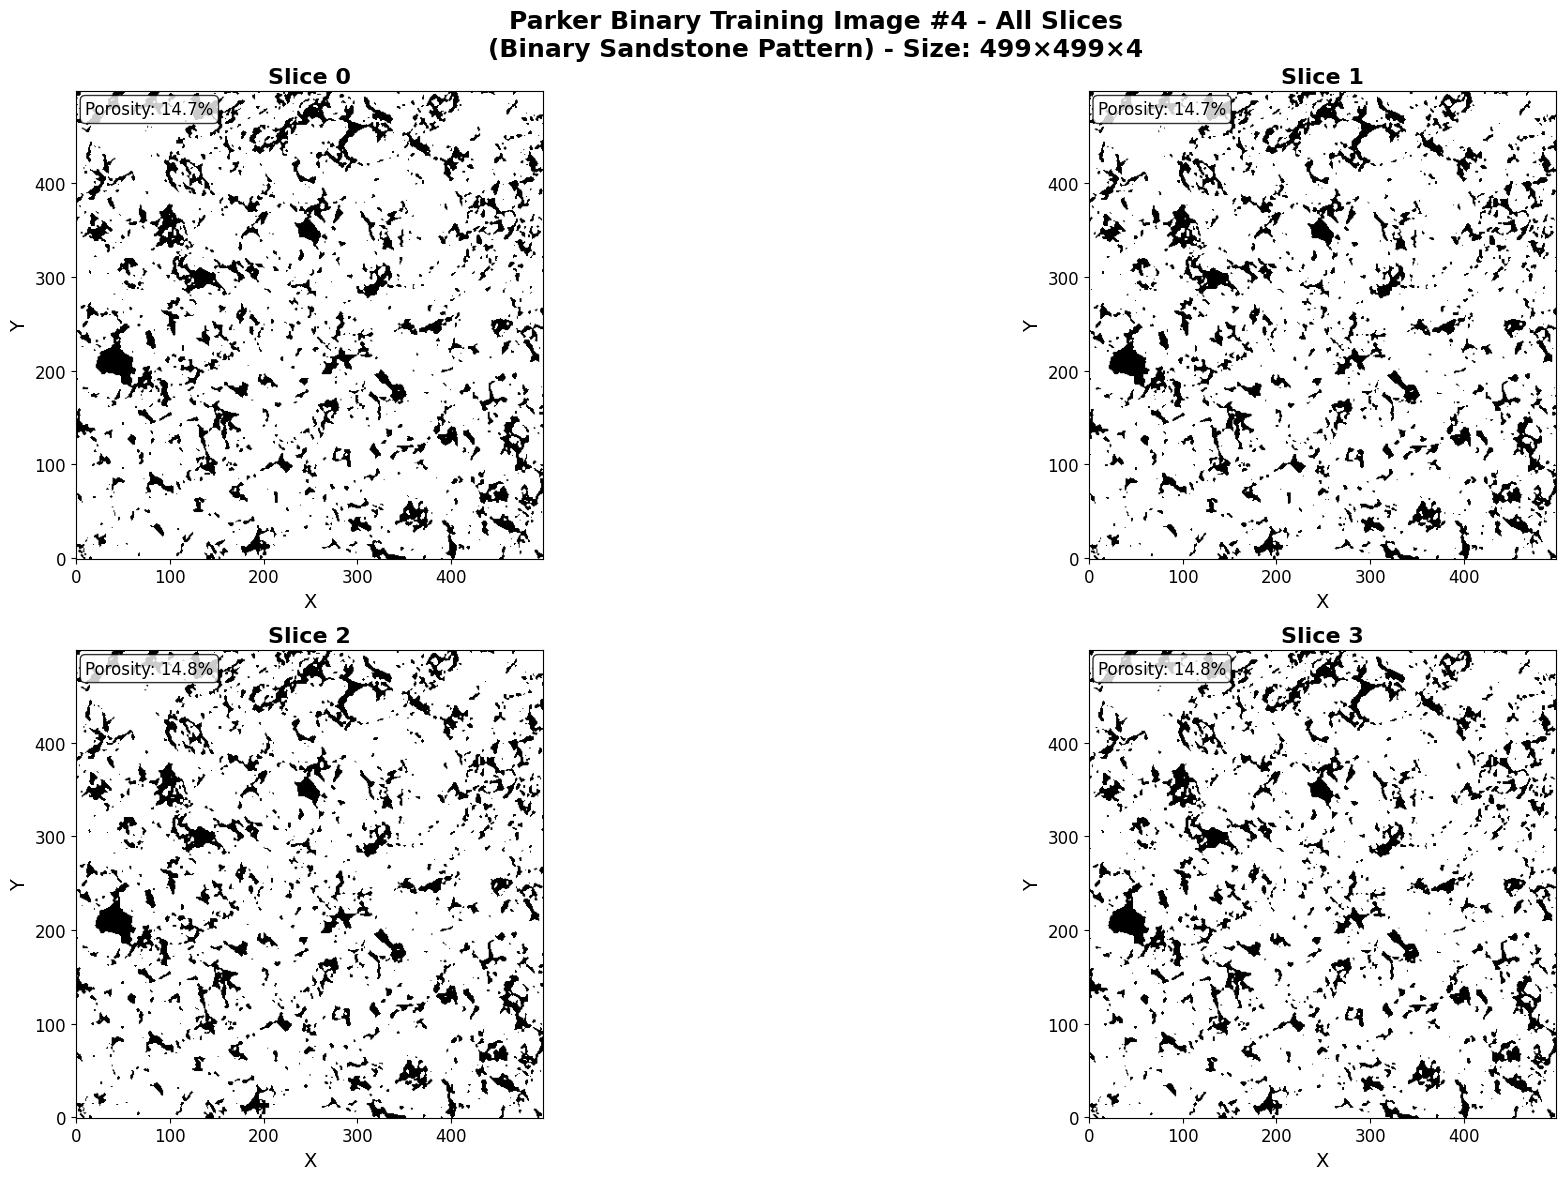

In [ ]:
# Plot all slices in a grid with 2 images per row for better visibility
n_slices = data_transformed_array.shape[2]
cols = 2  # Fixed 2 columns per row
rows = (n_slices + cols - 1) // cols  # Calculate rows needed

plt.figure(figsize=(12*cols, 6*rows))  # Large figure size with 2 columns
for i in range(n_slices):
    plt.subplot(rows, cols, i+1)
    plt.imshow(data_transformed_array[:,:,i].T, cmap='plasma', origin='lower')
    plt.title(f'Slice {i}', fontsize=16, fontweight='bold')
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add statistics to help identify differences
    unique_vals = np.unique(data_transformed_array[:,:,i])
    porosity = np.mean(data_transformed_array[:,:,i] == 0) * 100
    plt.text(0.02, 0.98, f'Porosity: {porosity:.1f}%', 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle(f'Parker Binary Training Image #{idx} - All Slices\n(Binary Sandstone Pattern) - Size: {data_transformed_array.shape[0]}×{data_transformed_array.shape[1]}×{data_transformed_array.shape[2]}', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


# Simulation and parameters

In [9]:
O.par['ti_fnam'] = path + ".dat"

In [10]:
O.par

{'n_real': 25,
 'rseed': 1,
 'n_max_cpdf_count': 1,
 'out_folder': '.',
 'ti_fnam': '../data/eas/Parker_binary_4.dat',
 'simulation_grid_size': array([250, 250,   1]),
 'origin': array([0., 0., 0.]),
 'grid_cell_size': array([1, 1, 1]),
 'mask_fnam': 'mask.dat',
 'hard_data_fnam': 'hard.dat',
 'shuffle_simulation_grid': 2,
 'entropyfactor_simulation_grid': 4,
 'shuffle_ti_grid': 1,
 'hard_data_search_radius': 1,
 'soft_data_categories': array([0, 1]),
 'soft_data_fnam': 'soft.dat',
 'n_threads': 10,
 'debug_level': -1,
 'do_estimation': 0,
 'do_entropy': 1,
 'template_size': array([8, 7, 1]),
 'n_multiple_grids': 3,
 'n_min_node_count': 0,
 'n_cond': 10}

In [11]:
O.run_parallel()

parallel: Using 9 of max 10 threads


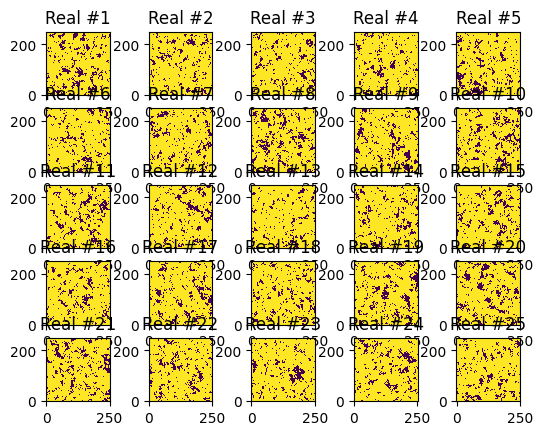

In [12]:
O.plot_reals()

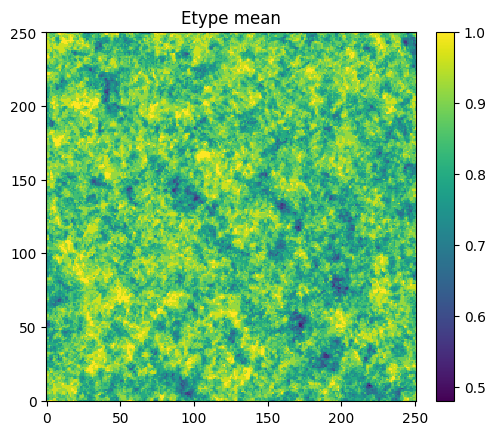

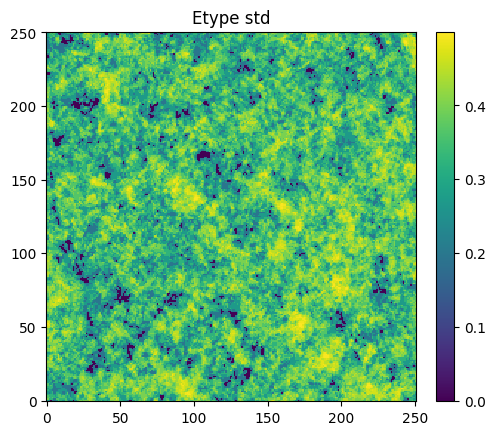

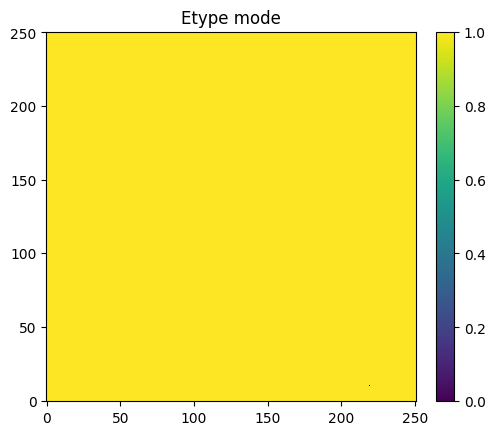

In [13]:
O.plot_etype()

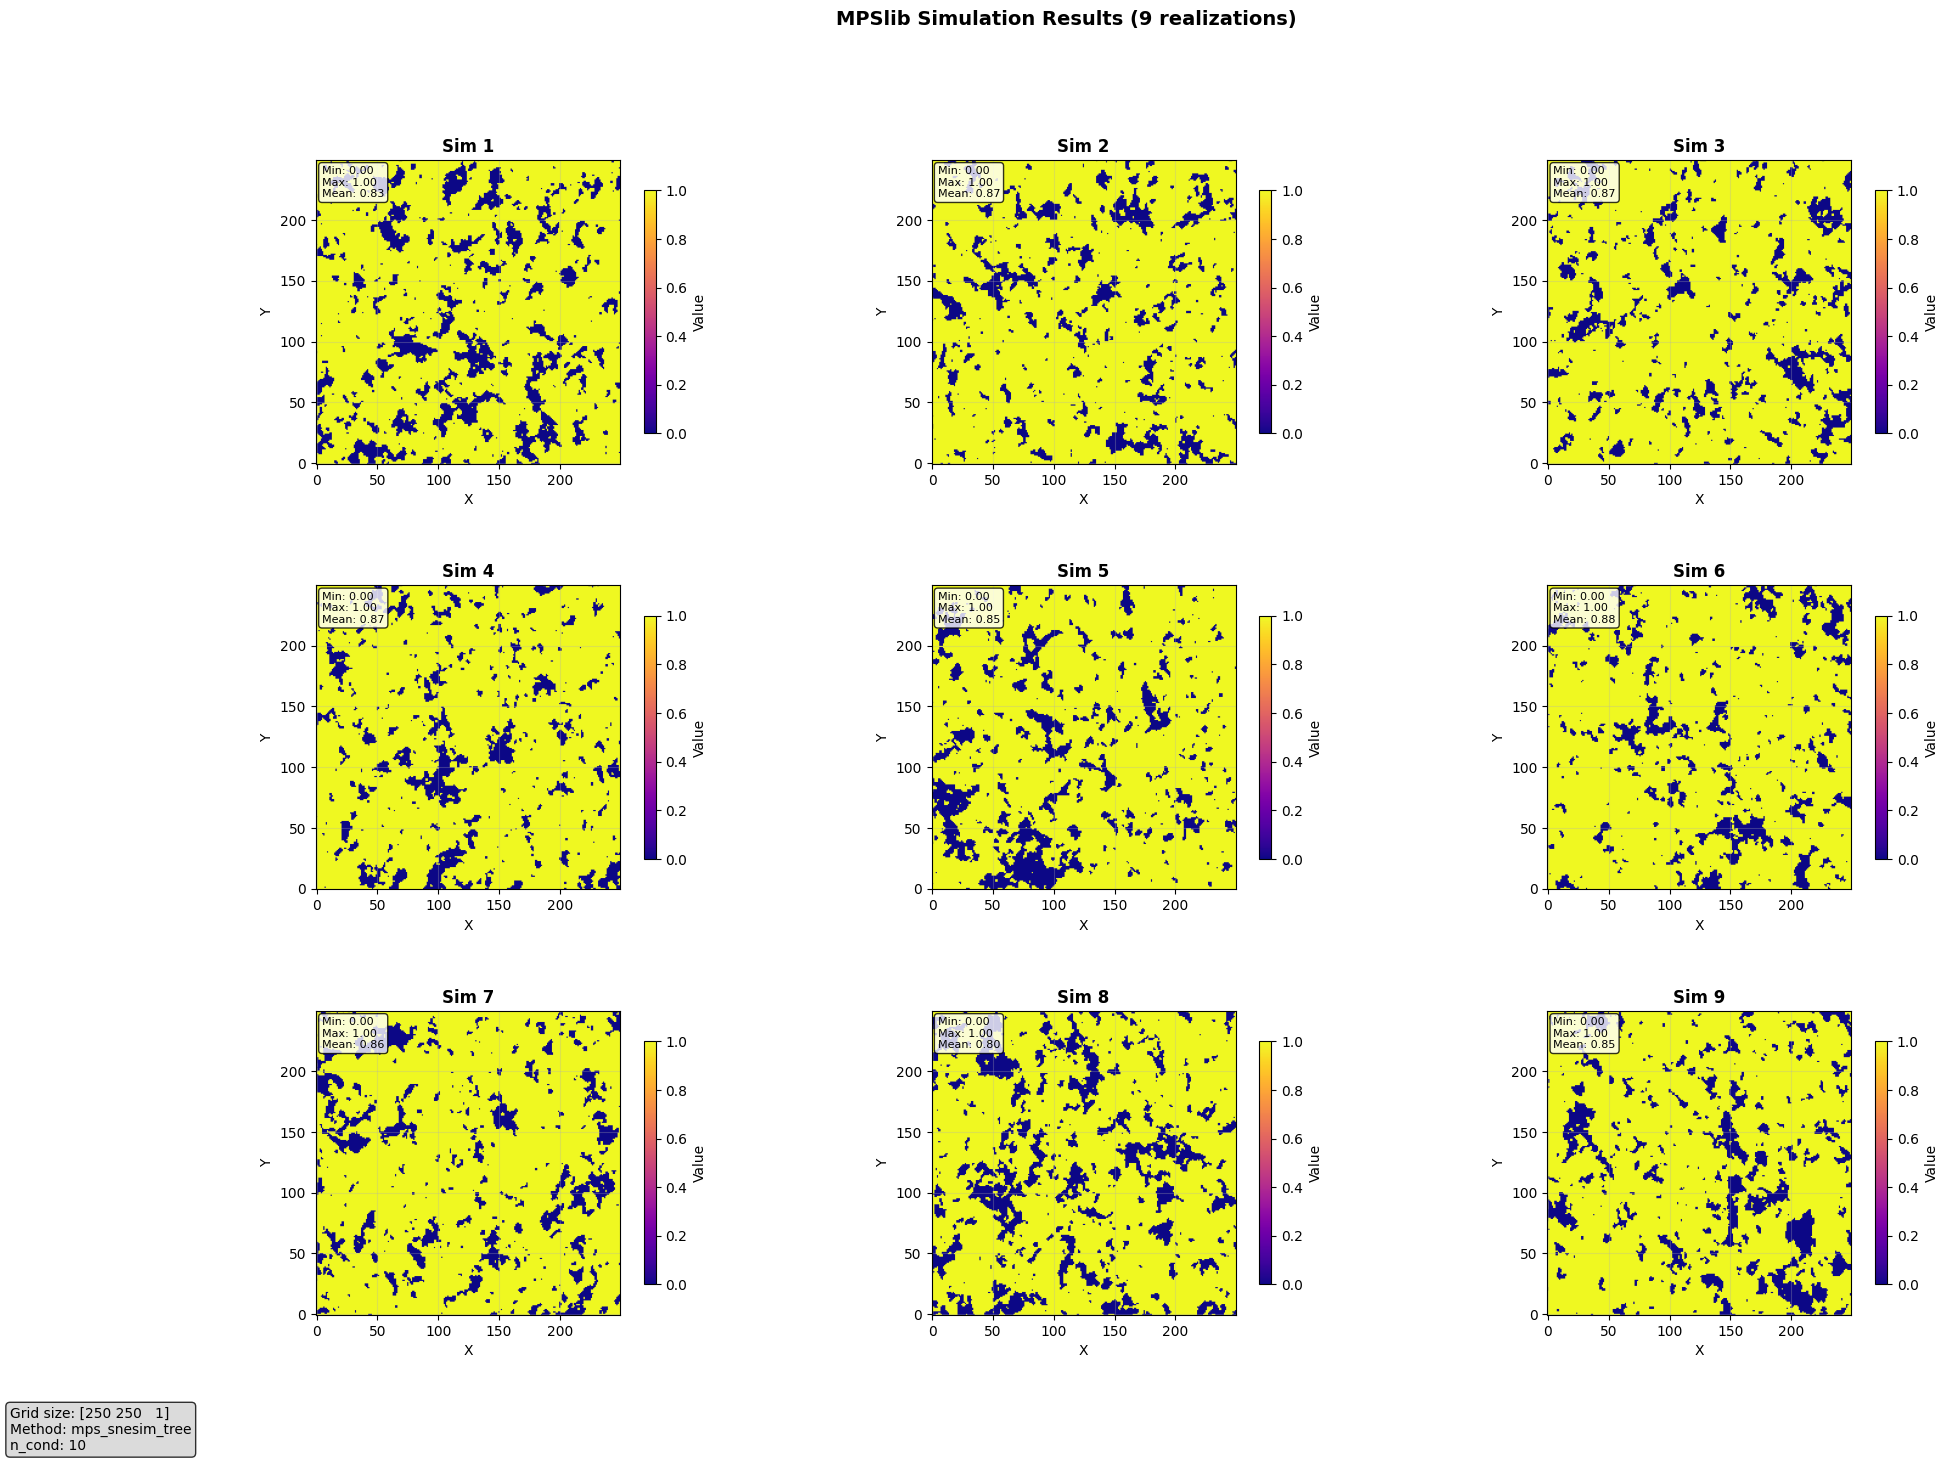

In [28]:
# Advanced usage
images = plot_realizations_enhanced(
    O, 
    n_realizations=9,           # Plot 6 realizations
    figsize=(22, 15),          # Larger figure
    cmap='plasma',             # Different colormap
    title_prefix="Sim",        # Custom title prefix
    # save_path="results.png",   # Save the plot
    # dpi=300                    # High resolution
)